In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import wandb
from datetime import timedelta
import matplotlib.pyplot as plt
import joblib
from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw

In [50]:
# wandb.init(
#     entity="gsu-dmlab",
#     project="SEPCFE",  # You choose the project name
#     name="Native_Guide_Exp1_EDA_ModelTraining",  # Give each run a name
# )

In [24]:
label_file = '../../data/raw/class_labels.csv'
data_dir = '../../data/raw/data/'

df_labels = pd.read_csv(label_file)
label_map = dict(zip(df_labels['File'], df_labels['Label']))

start_offset_min=300
end_offset_min=660
cols_to_keep = ['p3_flux_ic', 'p5_flux_ic', 'p7_flux_ic', 'long']
timestamps_list=[]
filenames=[]
X_list = []
y = []
meta_list = []  # store metadata (filename + timestamps)

for fname in os.listdir(data_dir):
    if fname.endswith('.csv') and fname in label_map and fname != '2005-09-07_14-25.csv':
        file_path = os.path.join(data_dir, fname)
        ts_df = pd.read_csv(file_path, sep=",")
        ts_df = ts_df.rename(columns={'time_tag': 'time_stamp'})
        ts_df['time_stamp'] = pd.to_datetime(ts_df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

        event_start = ts_df['time_stamp'].iloc[0] + timedelta(minutes=start_offset_min)
        event_end = ts_df['time_stamp'].iloc[0] + timedelta(minutes=end_offset_min)
        df_obs = ts_df[(ts_df['time_stamp'] >= event_start) & (ts_df['time_stamp'] < event_end)].copy()

        row_dict = {col: pd.Series(df_obs[col].values) for col in cols_to_keep}
        X_list.append(row_dict)
        y.append(label_map[fname])

        # save metadata for traceability
        meta_list.append({
            "filename": fname,
            "timestamps": df_obs["time_stamp"].tolist()
        })

X = pd.DataFrame(X_list)
y = np.array(y)
meta = pd.DataFrame(meta_list)


In [25]:
X_temp, X_test, y_temp, y_test, meta_temp, meta_test = train_test_split(
    X, y, meta, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
    X_temp, y_temp, meta_temp, test_size=0.17, random_state=42, stratify=y_temp
)


In [26]:
print(X.shape, type(X),X_train.shape, type(X_train))

(2891, 4) <class 'pandas.core.frame.DataFrame'> (2039, 4) <class 'pandas.core.frame.DataFrame'>


In [27]:
def trace_back(idx,dataset):
    return {
        "label": dataset[idx],
        "filename": meta_test.iloc[idx]["filename"],
        "timestamps": meta_test.iloc[idx]["timestamps"][0]
    }

print(trace_back(5,y_test))


{'label': 0, 'filename': '1990-10-18_05-12.csv', 'timestamps': Timestamp('1990-10-18 10:12:00')}


In [28]:
from sktime.datatypes._panel._convert import from_nested_to_3d_numpy

X_train_3D = from_nested_to_3d_numpy(X_train[cols_to_keep])  # shape: (n_samples, n_channels, n_timepoints)
X_val_3D  = from_nested_to_3d_numpy(X_val[cols_to_keep])
X_test_3D  = from_nested_to_3d_numpy(X_test[cols_to_keep])


In [29]:
print(X_train_3D.shape, type(X_train_3D) , X_test_3D.shape, type(X_test_3D))

(2039, 4, 360) <class 'numpy.ndarray'> (434, 4, 360) <class 'numpy.ndarray'>


In [8]:
# from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
# import joblib
# model = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw",)
# model.fit(X_train_3D, y_train)
#
# joblib.dump(model, '../../models/KNN_1_TS__classifier_v1.3.pkl')

In [30]:
model = joblib.load('../../models/KNN_1_TS__classifier_v1.3.pkl')

In [31]:
from sklearn.metrics import accuracy_score

y_val_pred = model.predict(X_val_3D)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Test
y_pred = model.predict(X_test_3D)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Validation accuracy: 0.9521531100478469
Test accuracy: 0.9516129032258065


In [32]:
tp_mask = (y_pred == 1) & (y_test == 1)
tp_indices_test = np.where(tp_mask)[0]
tp_test = X_test_3D[tp_indices_test]
print("True positive indices:", tp_indices_test)
print("Number of TPs in test data:", len(tp_indices_test))

tp_mask = (y_val_pred == 1) & (y_val == 1)
tp_indices_val = np.where(tp_mask)[0]
tp_val = X_test_3D[tp_indices_val]
print("True positive indices:", tp_indices_val)
print("Number of TPs in validation data:", len(tp_indices_val))


True positive indices: [ 31  41  49  56  66  71  72 101 110 117 118 120 134 174 231 236 251 270
 329 335 350 413 424]
Number of TPs in test data: 23
True positive indices: [ 28  71  74  99 119 141 143 147 154 157 174 175 190 195 222 223 249 266
 285 313 397]
Number of TPs in validation data: 21


In [33]:
def native_guide_retrieval_mvts(query, predicted_label, distance="dtw", n_neighbors=3):
    """
    Retrieve nearest unlike neighbors for a multivariate time series query.

    query: array of shape (n_channels, n_timepoints)
    predicted_label: the label to avoid
    distance: distance metric, e.g., 'dtw'
    n_neighbors: number of neighbors to retrieve
    """
    # Find indices of unlike neighbors
    unlike_indices = np.where(y_train != predicted_label)[0]  # numpy indexing
    X_unlike = X_train_3D[unlike_indices, :, :]  # shape: (n_unlike, n_channels, n_timepoints)
    # print(X_unlike)
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric=distance)
    knn.fit(X_unlike)
    query_reshaped = query.reshape(1, query.shape[0], query.shape[1])# Reshape query to (1, n_channels, n_timepoints)
    dist, ind = knn.kneighbors(query_reshaped, return_distance=True)# Compute distances and indices
    neighbor_indices = unlike_indices[ind[0]]
    return dist[0], neighbor_indices


In [34]:
def plot_query(query,query_label):
    n_channels = query.shape[0]
    plt.figure(figsize=(12, 3 * n_channels))
    for i,ch in enumerate(cols_to_keep):
        plt.subplot(n_channels, 1, i+1)
        # Plot query
        plt.plot(query[i], label=f"Query (Class Label:{query_label})", color='red', linewidth=2)
        plt.title(f"{ch}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [35]:
def plot_query_and_neighbors(query,query_label, X_train_3D,y_train, neighbor_indices, title_suffix=""):
    """
    Plot the query time series and its nearest unlike neighbors.

    query: array of shape (n_channels, n_timepoints)
    X_train_3D: array of shape (n_samples, n_channels, n_timepoints)
    neighbor_indices: indices of neighbors in X_train_3D
    title_suffix: optional string to append to the plot title
    """
    n_channels = query.shape[0]
    plt.figure(figsize=(12, 3 * n_channels))
    for i,ch in enumerate(cols_to_keep):
        plt.subplot(n_channels, 1, i+1)
        plt.plot(query[i], label=f"Query (Class Label:{query_label})", color='red', linewidth=2)
        # Plot each neighbor
        for j, idx in enumerate(neighbor_indices):
            plt.plot(X_train_3D[idx, i, :], label=f"Unlike Nearest Neighbor {j+1}(Class Label:{y_train[idx]})", linestyle='--')

        plt.title(f"{ch} {title_suffix}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [36]:
def target_mvts(instance_3d, model):
    """
    Find the second-most likely class for a multivariate time series.
    instance_3d: shape (n_channels, n_timepoints)
    model: trained tslearn classifier
    """
    # Add batch dimension: (1, n_channels, n_timepoints)
    instance_batch = instance_3d[np.newaxis, :, :]
    # Get class probabilities
    probs = model.predict_proba(instance_batch)[0]
    # Return index of the second-highest probability
    target_class = np.argsort(probs)[-2]
    return target_class


In [37]:
def plot_mvts_cf(query, query_label,generated_cf,generated_cf_label, title="Query vs Counterfactual"):
    """
    query: np.ndarray of shape (n_channels, n_timepoints)
    generated_cf: np.ndarray of shape (n_channels, n_timepoints)
    """
    n_channels = query.shape[0]
    timepoints = query.shape[1]
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
    if n_channels == 1:
        axes = [axes]  # Make it iterable if only 1 channel
    for i,ch in enumerate(cols_to_keep):
        axes[i].plot(range(timepoints), query[i], label=f"Query (class_label:{query_label})", alpha=0.7)
        axes[i].plot(range(timepoints), generated_cf[i], label=f"Counterfactual (class label:{generated_cf_label})", alpha=0.7, linestyle="--")
        axes[i].set_title(f"{ch}")
        axes[i].legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [38]:
def get_generated_cf(query,insample_cf,knn_model,pred_threshold=0.5, beta_step=0):
    beta = 0
    pred_threshold=0.5
    target_class = target_mvts(query,knn_model)
    generated_cf = dtw_barycenter_averaging([query, insample_cf], weights = np.array([1-beta,beta]))
    prob_of_generated_cf_for_target_class = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target_class]

    while prob_of_generated_cf_for_target_class < pred_threshold and beta <=1.0:
        beta+=0.01
        generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([1-beta,beta]))
        prob_of_generated_cf_for_target_class = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target_class]

    # print("Beta used for CF:", beta)
    # print("Probability for target class:", prob_of_generated_cf_for_target_class)
    return generated_cf


In [21]:
query_index=int(10)
query = X_test_3D[query_index]  # shape (n_channels, n_timepoints)
pred_label = y_pred[query_index]
distances, neighbor_indices = native_guide_retrieval_mvts(
    query=query,
    predicted_label=pred_label,
    distance='dtw',
    n_neighbors=3
)
print(trace_back(query_index,y_test))
print("Distances to nearest unlike neighbors:", distances)
print("Indices of these unlike neighbors in X_train:", neighbor_indices)
print("Labels of these unlike neighbors:", y_train[neighbor_indices])



{'label': 0, 'filename': '2001-01-20_17-33.csv', 'timestamps': Timestamp('2001-01-20 22:33:00')}
Distances to nearest unlike neighbors: [1.24514954 1.30994923 1.401482  ]
Indices of these unlike neighbors in X_train: [1754 1380  116]
Labels of these unlike neighbors: [1 1 1]


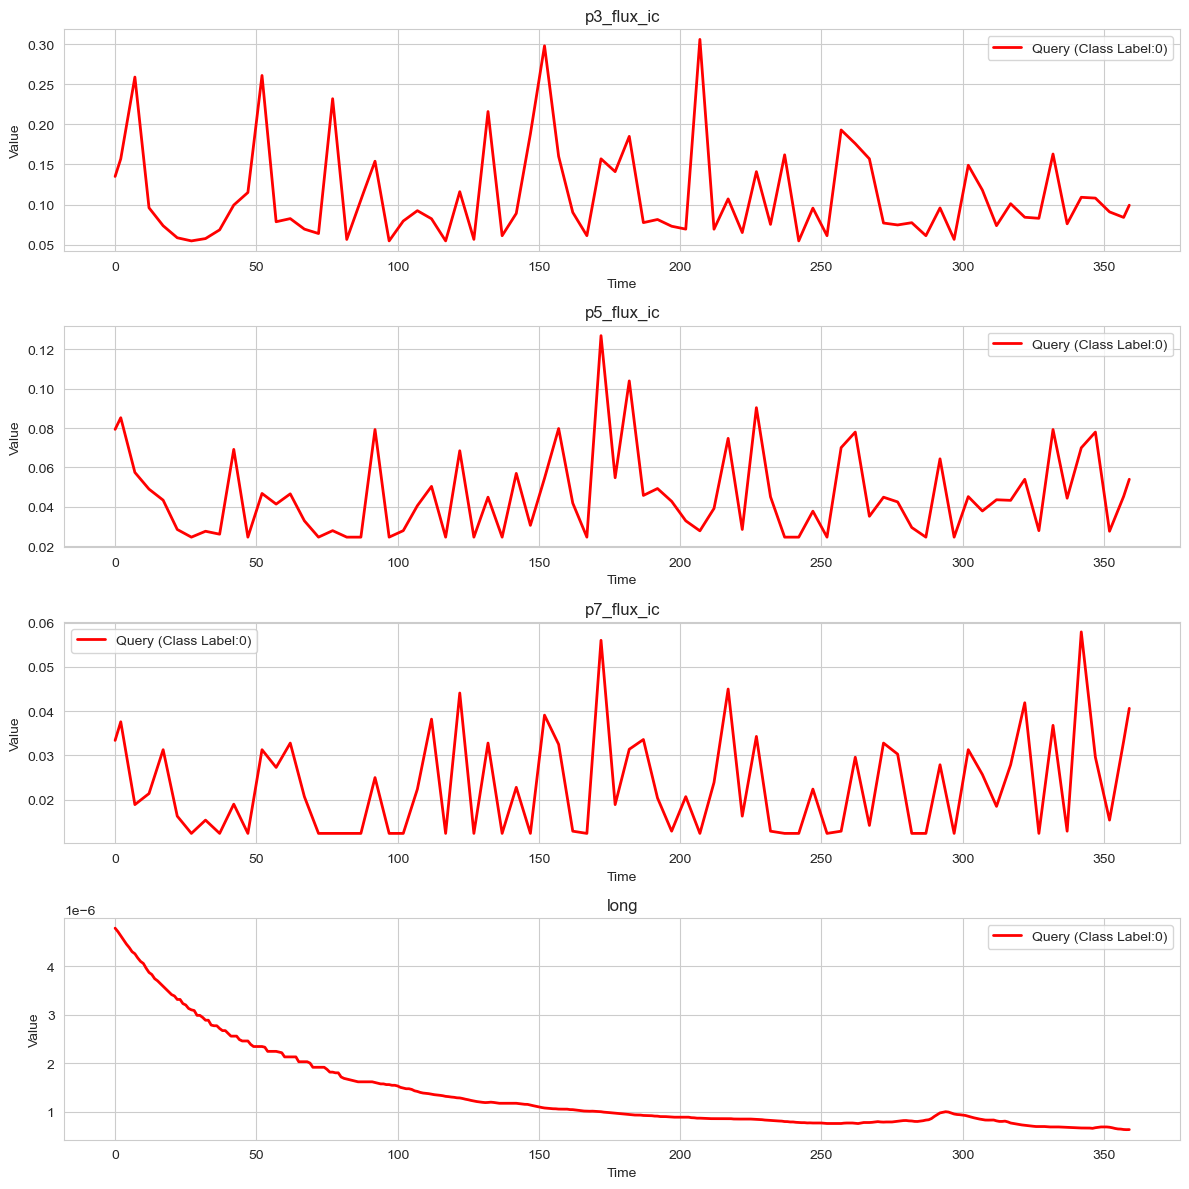

In [19]:
plot_query(query=X_test_3D[query_index], query_label=y_test[query_index])

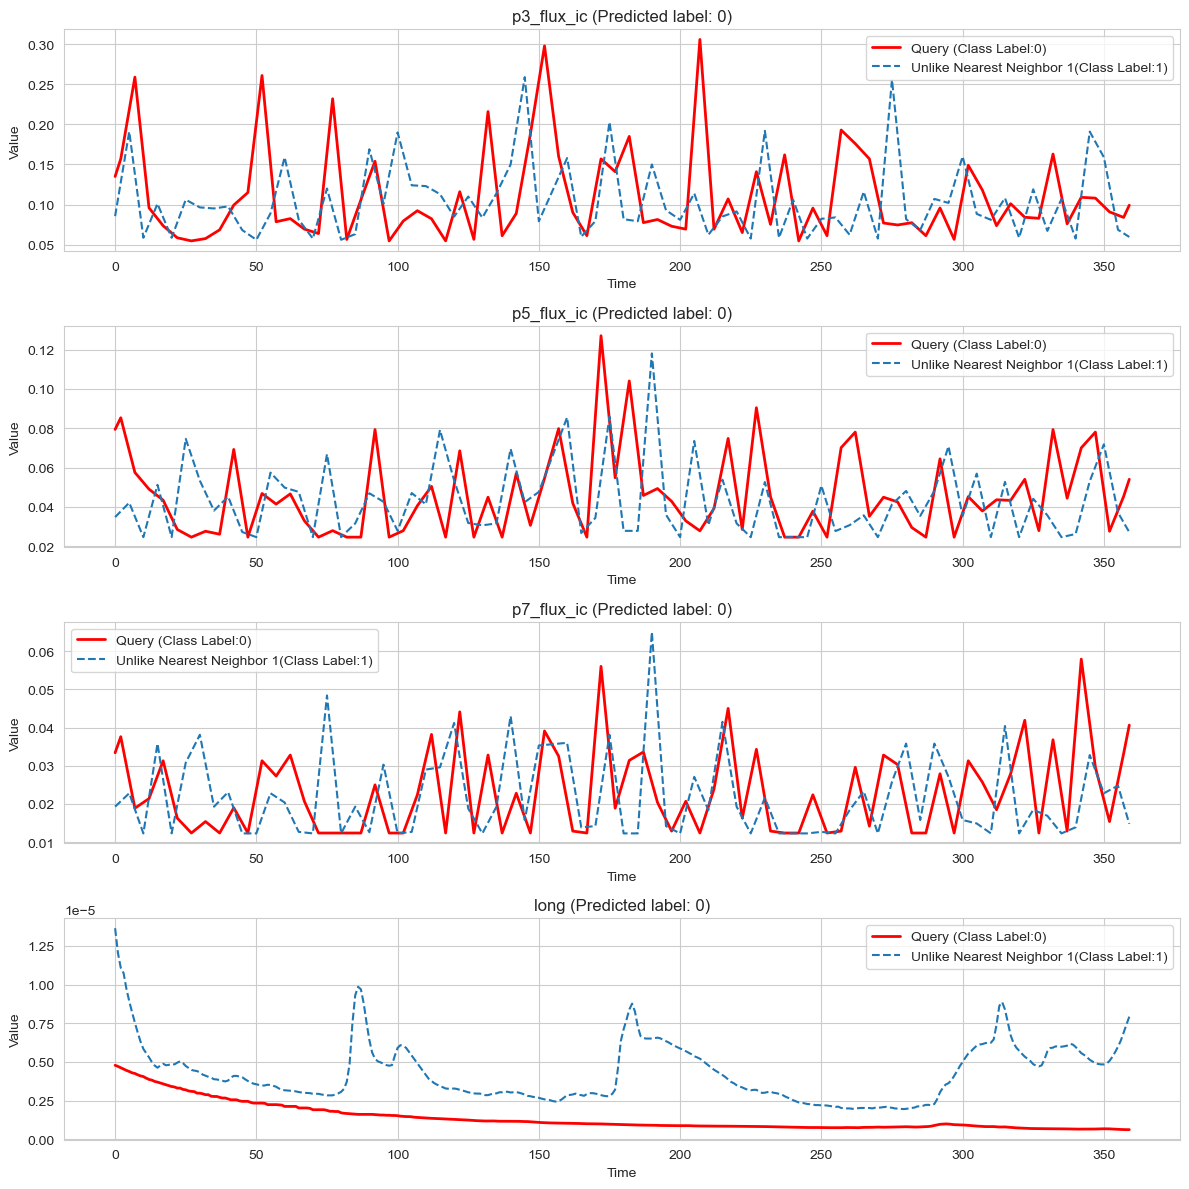

In [67]:
# Using the previous example
plot_query_and_neighbors(
    query=X_test_3D[query_index],
    query_label=y_test[query_index],
    X_train_3D=X_train_3D,
    y_train=y_train,
    neighbor_indices=[1754],
    title_suffix=f"(Predicted label: {pred_label})"
)


In [68]:
second_class = target_mvts(X_test_3D[query_index], model)
pred_class = y_pred[query_index]
print("Second Most likely class by probabilities:", second_class)
print("Predicted class:", pred_class)

Second Most likely class by probabilities: 1
Predicted class: 0


In [69]:
generated_cf = get_generated_cf(query = X_test_3D[query_index],insample_cf = X_train_3D[1380],knn_model=model)
generated_cf_reshaped = generated_cf.reshape(1, *generated_cf.shape)  # (1, n_channels, n_timepoints)
generated_cf_label = model.predict(generated_cf_reshaped)[0]
pred_probs = model.predict_proba(generated_cf_reshaped)[0]
print("Predicted label for Generated CF:", generated_cf_label)
print("Predicted probabilities:", pred_probs)
print("Most likely class:", pred_probs.argmax())

Beta used for CF: 0.5100000000000002
Probability for target class: 1.0
Predicted label for Generated CF: 1
Predicted probabilities: [0. 1.]
Most likely class: 1


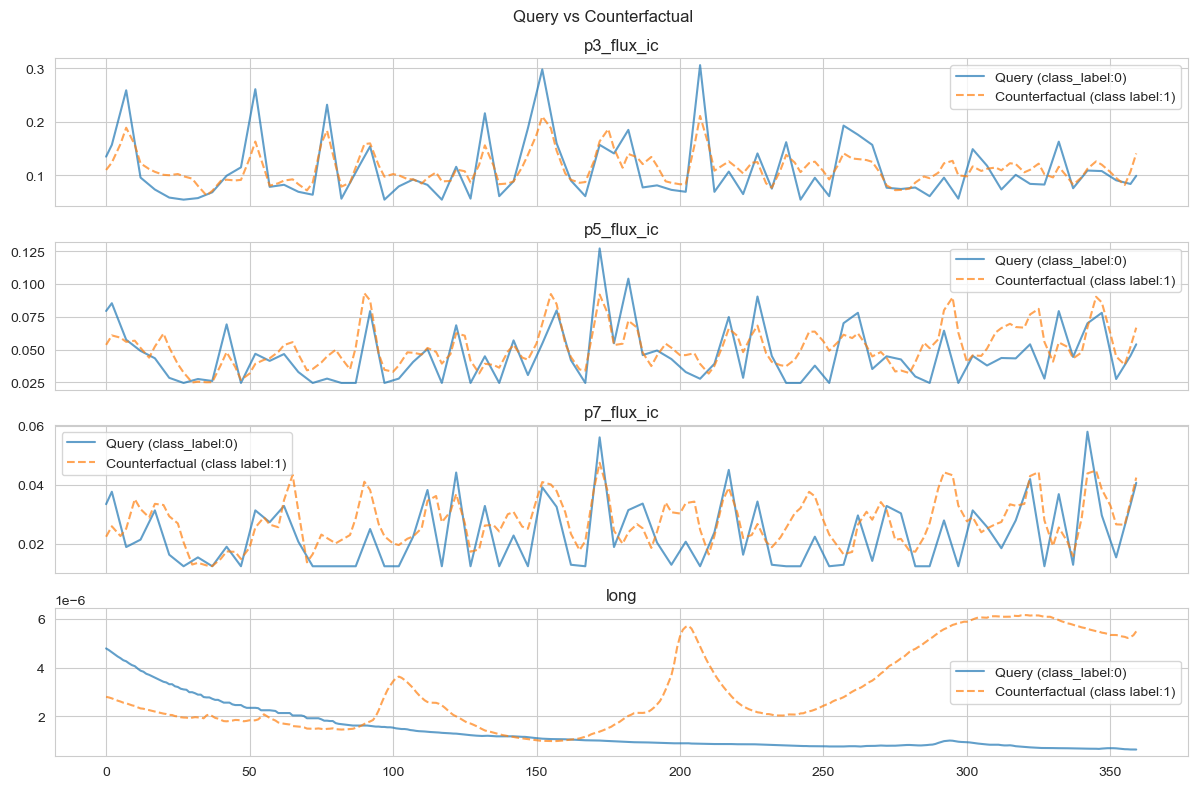

In [70]:
plot_mvts_cf(X_test_3D[query_index],y_test[query_index],generated_cf,generated_cf_label)

Example 2: SEP Event

In [115]:
query_index2=int(31)
query = X_test_3D[query_index2]  # shape (n_channels, n_timepoints)
pred_label = y_pred[query_index2]
distances, neighbor_indices = native_guide_retrieval_mvts(
    query=query,
    predicted_label=pred_label,
    distance='dtw',
    n_neighbors=3
)
print(trace_back(query_index2,y_test))
print("Distances to nearest unlike neighbors:", distances)
print("Indices of these unlike neighbors in X_train:", neighbor_indices)
print("Labels of these unlike neighbors:", y_train[neighbor_indices])




{'label': 1, 'filename': '2012-09-27_15-00.csv', 'timestamps': Timestamp('2012-09-27 20:00:00')}
Distances to nearest unlike neighbors: [7.59192898 9.39650503 9.94711534]
Indices of these unlike neighbors in X_train: [1172 1239 1752]
Labels of these unlike neighbors: [0 0 0]


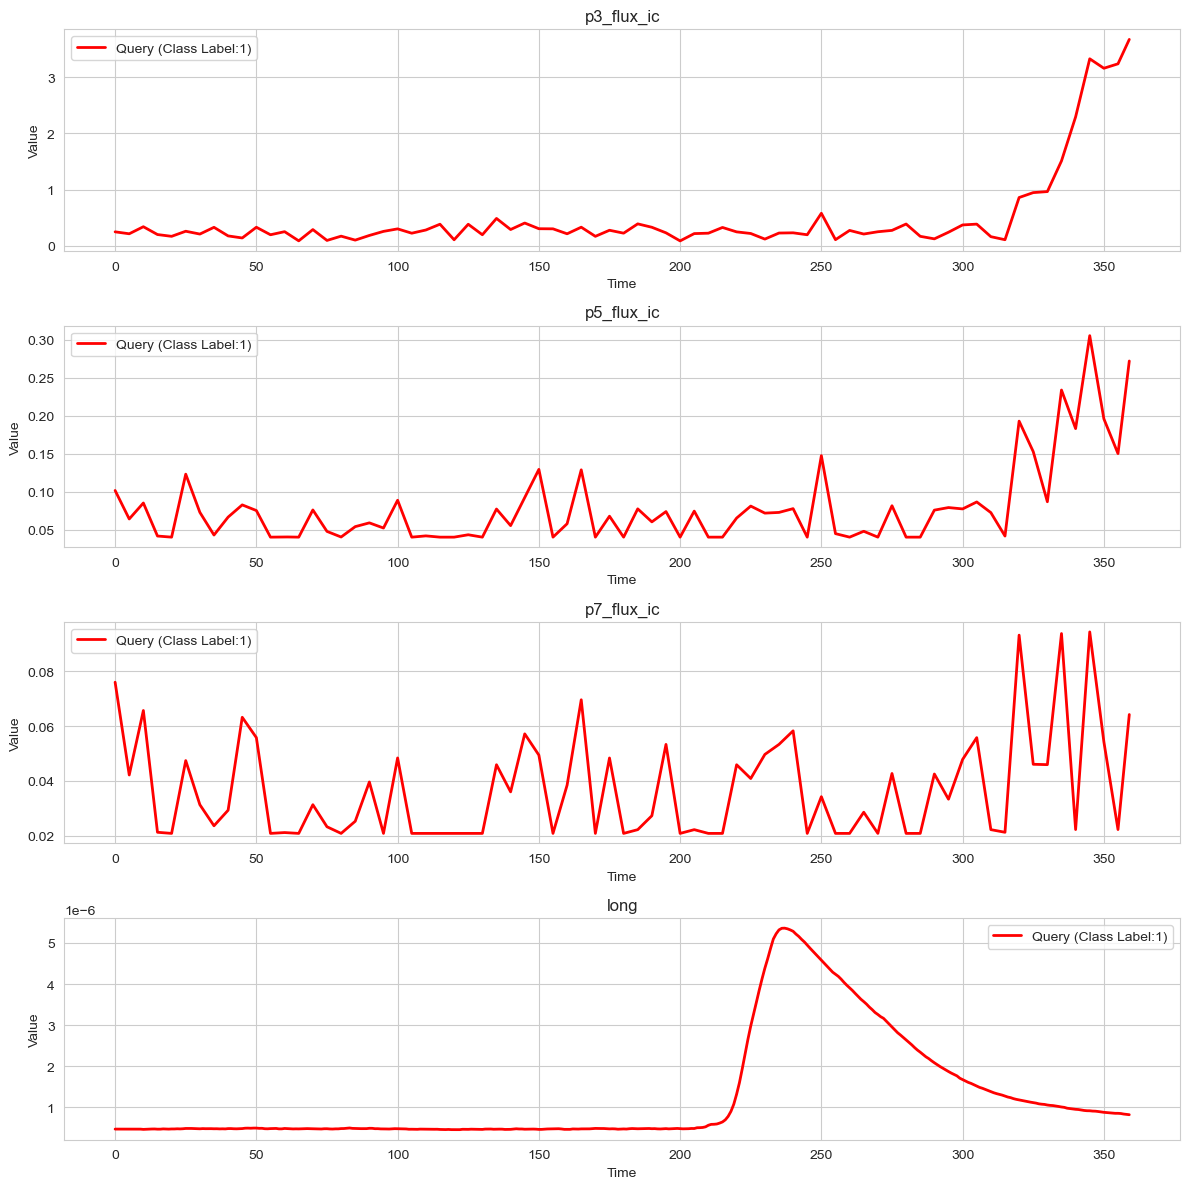

In [116]:
plot_query(query=X_test_3D[query_index2], query_label=y_test[query_index2])

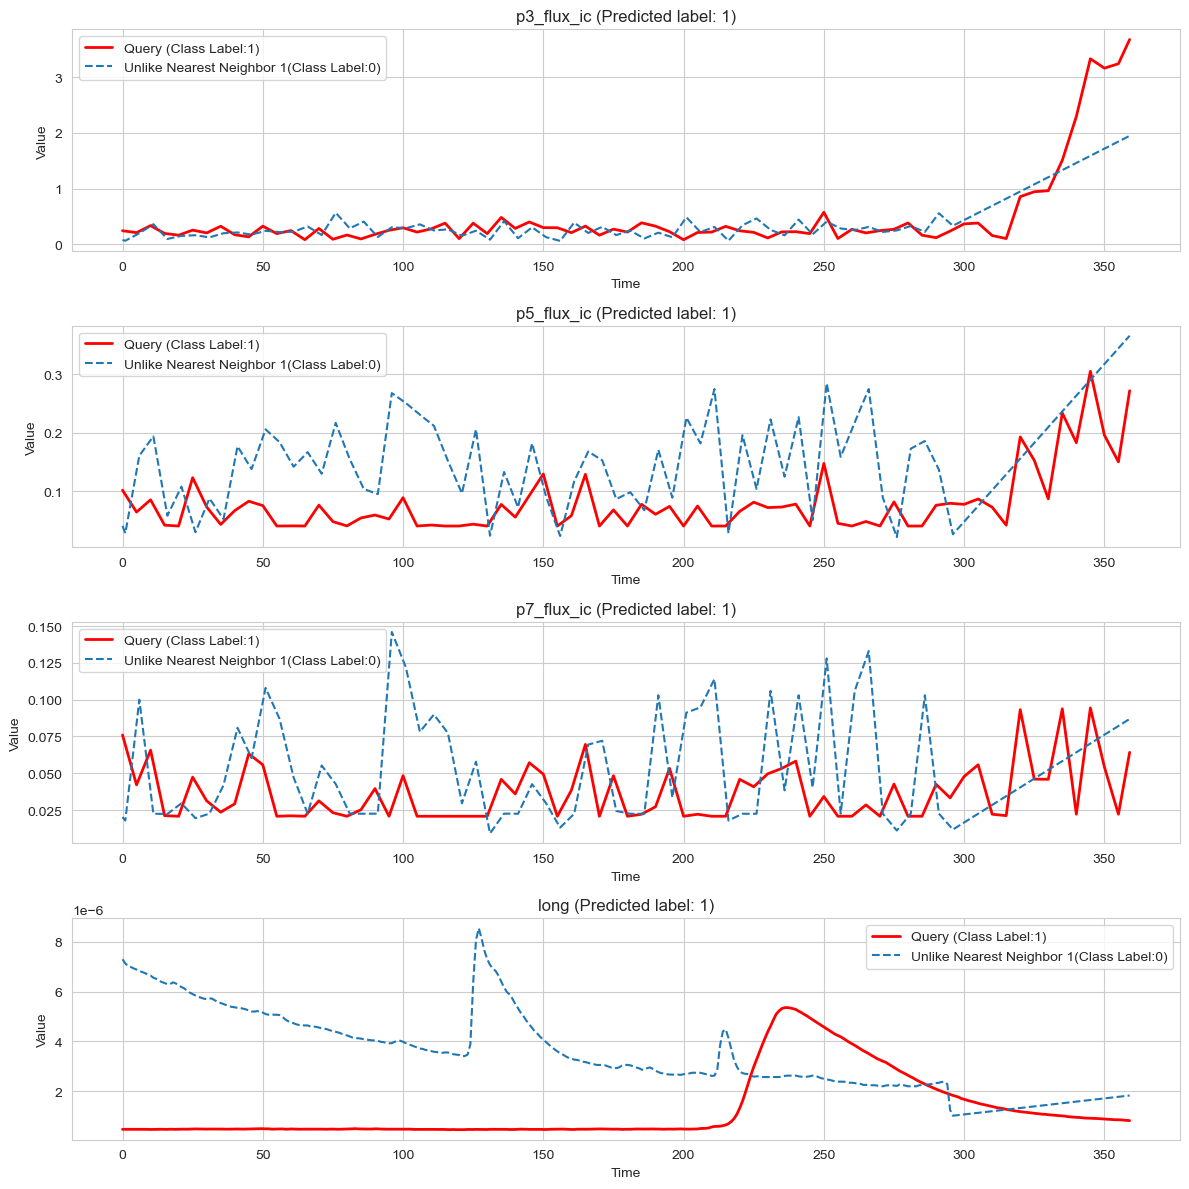

In [117]:
# Using the previous example
plot_query_and_neighbors(
    query=X_test_3D[query_index2],
    query_label=y_test[query_index2],
    X_train_3D=X_train_3D,
    y_train=y_train,
    neighbor_indices=[1172],
    title_suffix=f"(Predicted label: {pred_label})"
)


In [118]:
second_class = target_mvts(X_test_3D[query_index2], model)
pred_class = y_pred[query_index2]
print("Second Most likely class by probabilities:", second_class)
print("Predicted class:", pred_class)

Second Most likely class by probabilities: 0
Predicted class: 1


In [119]:
generated_cf = get_generated_cf(query = X_test_3D[query_index2],insample_cf = X_train_3D[1172],knn_model=model)
generated_cf_reshaped = generated_cf.reshape(1, *generated_cf.shape)  # (1, n_channels, n_timepoints)
generated_cf_label = model.predict(generated_cf_reshaped)[0]
pred_probs = model.predict_proba(generated_cf_reshaped)[0]
print("Predicted label for Generated CF:", generated_cf_label)
print("Predicted probabilities:", pred_probs)
print("Most likely class:", pred_probs.argmax())


Beta used for CF: 0.45000000000000023
Probability for target class: 1.0
Predicted label for Generated CF: 0
Predicted probabilities: [1. 0.]
Most likely class: 0


In [120]:
type(generated_cf)

numpy.ndarray

In [121]:
generated_cf.shape

(4, 360)

In [122]:
type(X_test[0])

KeyError: 0

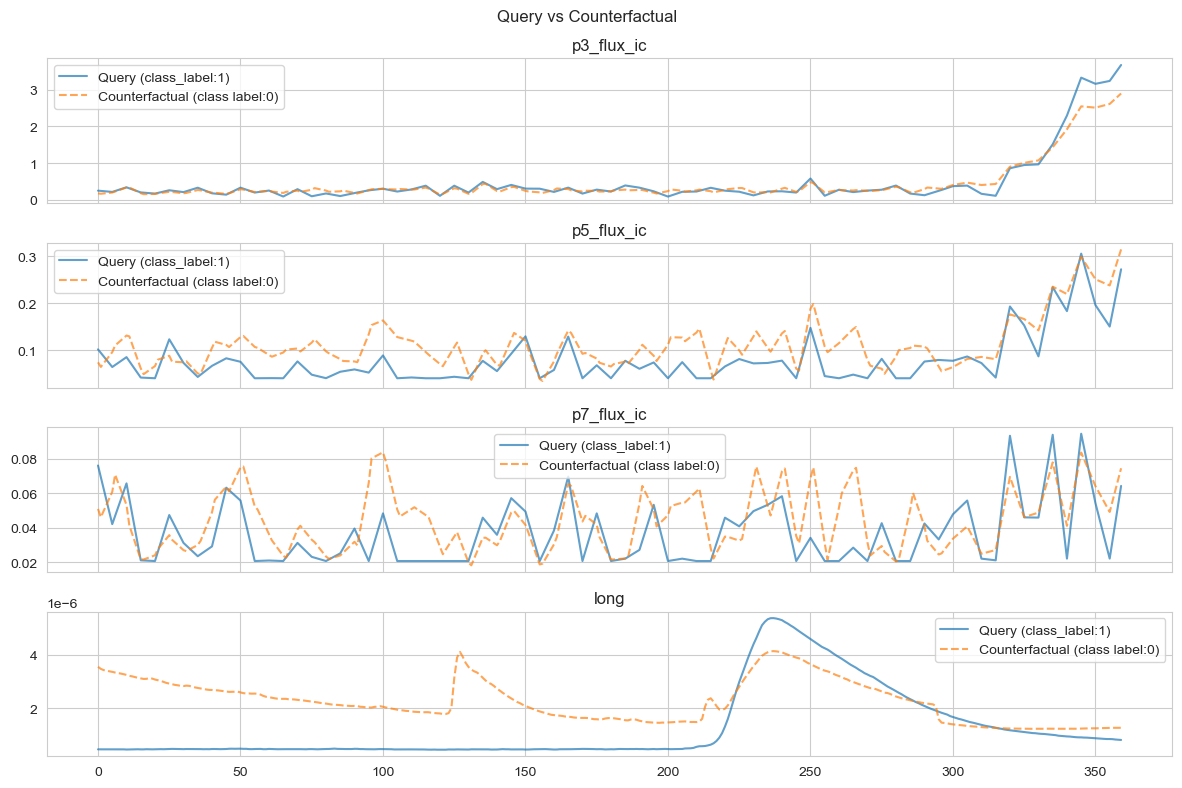

In [76]:
plot_mvts_cf(X_test_3D[query_index2],y_test[query_index2],generated_cf,generated_cf_label)

## Fidelity Evaluation on Test Data

In [82]:
def batch_cf_pipeline(X_test_3D, y_test, y_pred, X_train_3D, y_train, model, query_indices, n_neighbors=3):
    results = []

    for q_idx in query_indices:
        query = X_test_3D[q_idx]
        pred_label = y_pred[q_idx]

        # Step 1: neighbors
        distances, neighbor_indices = native_guide_retrieval_mvts(
            query, pred_label, "dtw", n_neighbors=n_neighbors
        )

        # Step 2: generate CF
        generated_cf = get_generated_cf(query, X_train_3D[neighbor_indices[0]], model)
        generated_cf_label = model.predict(generated_cf[np.newaxis, :, :])[0]

        # Save results
        results.append({
            "query_index": q_idx,
            "true_label": y_test[q_idx],
            "pred_label": pred_label,
            "neighbors": neighbor_indices,
            "cf": generated_cf,
            "cf_label": generated_cf_label
        })

    return results


In [83]:
query_indices = list(range(100))   # first 100 test instances
results = batch_cf_pipeline(X_test_3D, y_test, y_pred, X_train_3D, y_train, model, query_indices)

print(results[0]["neighbors"])  # neighbors for the first query


Beta used for CF: 0.3000000000000001
Probability for target class: 1.0
Beta used for CF: 0.47000000000000025
Probability for target class: 1.0
Beta used for CF: 0.4100000000000002
Probability for target class: 1.0
Beta used for CF: 0.3300000000000001
Probability for target class: 1.0
Beta used for CF: 0.4200000000000002
Probability for target class: 1.0
Beta used for CF: 0.5600000000000003
Probability for target class: 1.0
Beta used for CF: 0.3100000000000001
Probability for target class: 1.0
Beta used for CF: 0.46000000000000024
Probability for target class: 1.0
Beta used for CF: 0.3000000000000001
Probability for target class: 1.0
Beta used for CF: 0.2700000000000001
Probability for target class: 1.0
Beta used for CF: 0.46000000000000024
Probability for target class: 1.0
Beta used for CF: 0.21000000000000005
Probability for target class: 1.0
Beta used for CF: 0.5100000000000002
Probability for target class: 1.0
Beta used for CF: 0.45000000000000023
Probability for target class: 1.0
B

In [84]:
def evaluate_fidelity(results, target_class=None):
    """
    Compute fidelity of CFs.
    If target_class is given, checks CF == target_class.
    Otherwise, checks CF != original prediction (flip rate).
    """
    total = len(results)
    correct = 0

    for r in results:
        if target_class is not None:
            if r["cf_label"] == target_class:
                correct += 1
        else:
            # assume CF should flip original prediction
            if r["cf_label"] != r["pred_label"]:
                correct += 1

    fidelity = correct / total if total > 0 else 0
    return fidelity


In [85]:
# Fidelity = proportion of CFs that flipped the label
fidelity_score = evaluate_fidelity(results)

print(f"Fidelity on {len(query_indices)} test samples: {fidelity_score:.2f}")

Fidelity on 100 test samples: 1.00


In [90]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results[["cf_label", "pred_label"]]


,cf_label,pred_label
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
95,1,0
96,0,1
97,1,0
98,1,0


## Hyperparameter Tuning

In [ ]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
beta_steps = [0.01, 0.05]
hyperparameter_results = []

# Loop over hyperparameters
for th in thresholds:
    for b_step in beta_steps:
            success_rates = []
            dtw_distances = []

            for i in range(100):  # evaluate on first 100 validation samples
                query = X_val_3D[i]
                pred_label = model.predict(query[np.newaxis, :, :])[0]

                # retrieve unlike neighbor(s)
                _, neighbor_indices = native_guide_retrieval_mvts(query, pred_label, "dtw", n_neighbors=3)
                insample_cf = X_train_3D[neighbor_indices[0]]

                # generate CF
                generated_cf = get_generated_cf(query, insample_cf, model, pred_threshold=th, beta_step=b_step)

                cf_label = model.predict(generated_cf[np.newaxis, :, :])[0]

                # success if CF != predicted label
                success_rates.append(cf_label != pred_label)

                # distance metric (Euclidean between series)
                # dtw_distances.append(dtw(X_test[i].ravel(), generated_cf[i].ravel()))
                for ch in range(X_val_3D.shape[1]):  # for each channel
                    dtw_dist = dtw(X_val_3D[i, ch, :], generated_cf[ch, :])
                    dtw_distances.append(dtw_dist)



            # Save averaged results
            hyperparameter_results.append({
                "threshold": th,
                "beta_step": b_step,
                "n_neighbors": 3,
                "success_rate": np.mean(success_rates),
                "avg_distance": np.mean(dtw_distances),
                # "mode_distance": np.mode(dtw_distances),
                "median_distance": np.median(dtw_distances),
                "dtw_distances": dtw_distances
            })

df_results = pd.DataFrame(hyperparameter_results)
print(df_results.sort_values(by="success_rate", ascending=False))


In [127]:
X_test[cols_to_keep]

,p3_flux_ic,p5_flux_ic,p7_flux_ic,long
720,0 1.0300 1 1.0000 2 1.0420 3 ...,0 0.16200 1 0.13800 2 0.14880 3...,0 0.06048 1 0.05060 2 0.05210 3...,0 0.000004 1 0.000004 2 0.00000...
2865,0 0.168362 1 0.175440 2 0.16807...,0 0.057474 1 0.058717 2 0.05994...,0 0.033318 1 0.034185 2 0.03297...,0 7.488714e-07 1 7.466000e-07 2 ...
438,0 0.10000 1 0.08800 2 0.07600 3...,0 0.02994 1 0.03346 2 0.03698 3...,0 0.01338 1 0.01362 2 0.01386 3...,0 0.000002 1 0.000002 2 0.00000...
1834,0 0.14800 1 0.13630 2 0.12460 3...,0 0.04780 1 0.04960 2 0.05140 3...,0 0.01430 1 0.02016 2 0.02602 3...,0 0.000002 1 0.000002 2 0.00000...
1918,0 0.08268 1 0.07892 2 0.07516 3...,0 0.05228 1 0.04852 2 0.04476 3...,0 0.03848 1 0.03472 2 0.03096 3...,0 1.728571e-06 1 1.642857e-06 2 ...
...,...,...,...,...
1170,0 0.1472 1 0.1638 2 0.1804 3 ...,0 0.06632 1 0.07428 2 0.08224 3...,0 0.02806 1 0.02984 2 0.03162 3...,0 2.628571e-07 1 2.600000e-07 2 ...
1074,0 0.1506 1 0.1570 2 0.1544 3 ...,0 0.10440 1 0.11100 2 0.10830 3...,0 0.02668 1 0.02670 2 0.02670 3...,0 5.928571e-07 1 5.985714e-07 2 ...
1054,0 0.3424 1 0.3596 2 0.3768 3 ...,0 0.1984 1 0.1666 2 0.1348 3 ...,0 0.07984 1 0.06176 2 0.04368 3...,0 6.771429e-07 1 6.685714e-07 2 ...
958,0 0.1742 1 0.1696 2 0.1650 3 ...,0 0.13280 1 0.12840 2 0.12400 3...,0 0.05478 1 0.05214 2 0.04950 3...,0 7.728571e-07 1 7.800000e-07 2 ...
